<a href="https://colab.research.google.com/github/lora-blanc/2-/blob/master/diploma(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала загрузим файл с партиями с Yandex Disk, обработаем данные и представим в виде матрицы

In [3]:
import requests
from urllib.parse import urlencode

def load_file(name, url):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  public_key = url  # Сюда вписываем ссылку на Yandex Disk, c нужным нам файлом

  # Получаем загрузочную ссылку
  final_url = base_url + urlencode(dict(public_key=public_key))
  response = requests.get(final_url)
  download_url = response.json()['href']

  # Загружаем файл и сохраняем его
  download_response = requests.get(download_url)
  with open(name, 'wb') as f: 
    f.write(download_response.content)


Теперь мы должны распарсить полученный нами файл. Для этого будем использовать библиотеку Pandas

In [5]:
import pandas as pd

def parse_excel(name):
  data = pd.read_excel(name, usecols ="B:J")

  votes = pd.read_excel(name, usecols ="A")
  votes = votes.values.tolist()

  parties = (pd.read_excel(name).columns.tolist()[1:])
  return data.values.tolist(), votes, parties

matrix, votes, parties = parse_excel('first.xlsx')
results = ['за', 'против', 'неучастие']


Для того, чтобы было удобно работать в Python, преобразуем данные во вложенный список в методе parse_excel. Теперь покажем, что у нас вышло:

In [6]:
print(matrix)

[['against', 'against', 'неучастие', 'неучастие', 'for', 'against', 'against', 'against', 'неучастие'], ['against', 'for', 'неучастие', 'неучастие', 'for', 'against', 'неучастие', 'for', 'неучастие'], ['against', 'for', 'неучастие', 'неучастие', 'for', 'неучастие', 'неучастие', 'for', 'неучастие'], ['неучастие', 'неучастие', 'неучастие', 'неучастие', 'for', 'неучастие', 'неучастие', 'against', 'against'], ['against', 'against', 'неучастие', 'неучастие', 'against', 'against', 'against', 'against', 'неучастие'], ['неучастие', 'for', 'неучастие', 'неучастие', 'неучастие', 'against', 'неучастие', 'неучастие', 'неучастие'], ['неучастие', 'for', 'неучастие', 'неучастие', 'неучастие', 'against', 'неучастие', 'неучастие', 'неучастие']]


Теперь заменим значения на числа по следующему правилу: 'for' - 0, 'against' - 1, 'неучастие' - 2. Так у нас получится взвешенный граф, где ребро между партией и голосованием будет соответствовать голосу за/против/воздержался

In [8]:
def format_matrix_to_numbers(matrix_unformatted):
  for i in range(0, len(matrix_unformatted)):
    for j in range(0, len(matrix_unformatted[0])):
      if (matrix_unformatted[i][j] == 'неучастие'):
        matrix_unformatted[i][j] = 3
      if (matrix_unformatted[i][j] == 'воздержались'):
        matrix_unformatted[i][j] = 2
      if (matrix_unformatted[i][j] == 'for'):
        matrix_unformatted[i][j] = 0
      if (matrix_unformatted[i][j] == 'against'):
        matrix_unformatted[i][j] = 1


format_matrix_to_numbers(matrix)
print(matrix)

[[1, 1, 3, 3, 0, 1, 1, 1, 3], [1, 0, 3, 3, 0, 1, 3, 0, 3], [1, 0, 3, 3, 0, 3, 3, 0, 3], [3, 3, 3, 3, 0, 3, 3, 1, 1], [1, 1, 3, 3, 1, 1, 1, 1, 3], [3, 0, 3, 3, 3, 1, 3, 3, 3], [3, 0, 3, 3, 3, 1, 3, 3, 3]]


Теперь мы будем брать по очереди ребра со значением 0, 1, 2 и делать следующее:

Оставляем ребра одного типа. Теперь проходимся по всем голосованиям, и добавляем в массив списки партий, проголосовавших одинаково в каждом голосовании. Так components состоит из списков, каждый список - это партиии, которые повели себя одинаково на каком-либо одинаково

In [9]:
def get_components_list(matrix1, maxvalue):

  components = []

  for type_edge in range(0, maxvalue+1):
    for i in range(0, len(matrix1)):
      list_parties = []
      for j in range(0, len(matrix1[0])):
        if (matrix1[i][j]==type_edge):
          list_parties.append(j)
      components.append(list_parties)
  return components

components_all = get_components_list(matrix, 3)
print(components_all)

[[4], [1, 4, 7], [1, 4, 7], [4], [], [1], [1], [0, 1, 5, 6, 7], [0, 5], [0], [7, 8], [0, 1, 4, 5, 6, 7], [5], [5], [], [], [], [], [], [], [], [2, 3, 8], [2, 3, 6, 8], [2, 3, 5, 6, 8], [0, 1, 2, 3, 5, 6], [2, 3, 8], [0, 2, 3, 4, 6, 7, 8], [0, 2, 3, 4, 6, 7, 8]]


Теперь нам нужно построить итоговый граф, с весами, в котором ребро весом n между вершинами v и u показывает, что n раз партии u и v повели себя одинаково на голосовании

In [10]:
def make_graph_matrix(components):

  graph_matrix = [[0] * len(parties) for _ in range(len(parties))]

  for i in range(0, len(components)):
    for first_elem in components[i]:
      for second_elem in components[i]:
        if (first_elem!=second_elem):
          graph_matrix[first_elem][second_elem]+=1
  return graph_matrix

graph_matrix_all = make_graph_matrix(components_all)

Теперь построим таблицу этих весов для наглядности, число в ячейке показывает, сколько раз эти партии одинаково вели себя на голосовании

In [11]:
print(pd.DataFrame(graph_matrix_all, parties, parties))

        АПС  Фидес  Йоббик  ДНП  Д5З  НПС  ПиС  ИФ  НФ
АПС       0      3       3    3    3    4    5   4   2
Фидес     3      0       1    1    3    3    3   4   0
Йоббик    3      1       0    7    2    2    5   2   6
ДНП       3      1       7    0    2    2    5   2   6
Д5З       3      3       2    2    0    1    3   5   2
НПС       4      3       2    2    1    0    4   2   1
ПиС       5      3       5    5    3    4    0   4   4
ИФ        4      4       2    2    5    2    4   0   3
НФ        2      0       6    6    2    1    4   3   0


Теперь нам нужно построить взвешенный граф из матрицы смежности, показать веса.

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure


def scalegraph(sf):  # scale graph by scalefactor = sf, keeping it centred
    plt.axis('off')
    axis = plt.gca()
    xlim=list(axis.get_xlim())
    ylim=list(axis.get_ylim())
    xav=sum(xlim)/2
    dx=(xlim[1]-xlim[0])/2
    yav=sum(ylim)/2
    dy=(ylim[1]-ylim[0])/2
    axis.set_xlim([xav-sf*dx,xav+sf*dx])
    axis.set_ylim([yav-sf*dy,yav+sf*dy])

def plot_heatmap(matrix_heat, labels):
  fig, ax = plt.subplots()
  sns.heatmap(matrix_heat, annot=True, cmap='coolwarm')
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
  plt.show()

def draw_graph_matrix_adjency(matrix_adjency, votes1):
  figure(figsize=(80, 60), dpi=80)
  G = nx.Graph()
  for i in range(0, len(matrix_adjency)):
    for j in range(0, len(matrix_adjency[0])):
      if (matrix_adjency[i][j]!=0):
        G.add_edge(parties[i], parties[j], weight=matrix_adjency[i][j])
  elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= len(votes1)/2]
  esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < len(votes1)/2]

  pos = nx.circular_layout(G)  # positions for all nodes

  # nodes
  nx.draw_networkx_nodes(G, pos, node_size=15000, node_color='lightblue')

  # edges
  nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
  nx.draw_networkx_edges(
      G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
  )

  # labels
  nx.draw_networkx_labels(G, pos, font_size=35, font_family="sans-serif")
  plt.axis("off")
  scalegraph(1)
  plt.show()

def make_graph(matrix_adjency, vertices):
  G = nx.Graph()
  for v in vertices:
    G.add_node(v)
  for i in range(0, len(matrix_adjency)):
    for j in range(0, len(matrix_adjency[0])):
      if (matrix_adjency[i][j]!=0):
        G.add_edge(vertices[i], vertices[j], weight=matrix_adjency[i][j])
  return G
  
# figure(figsize=(80, 60), dpi=80)
# draw_graph_matrix_adjency(graph_matrix_all, votes)

Теперь сделаем итоговую функцию, которая будет загружать данные по ссылке в файл и их сразу обрабатывать, выводить все нужные данные по файлу: матрицы смежности, графы

---Построим матрицу смежности и график с учетом, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

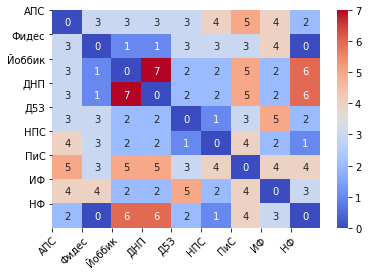

<Figure size 6400x4800 with 0 Axes>

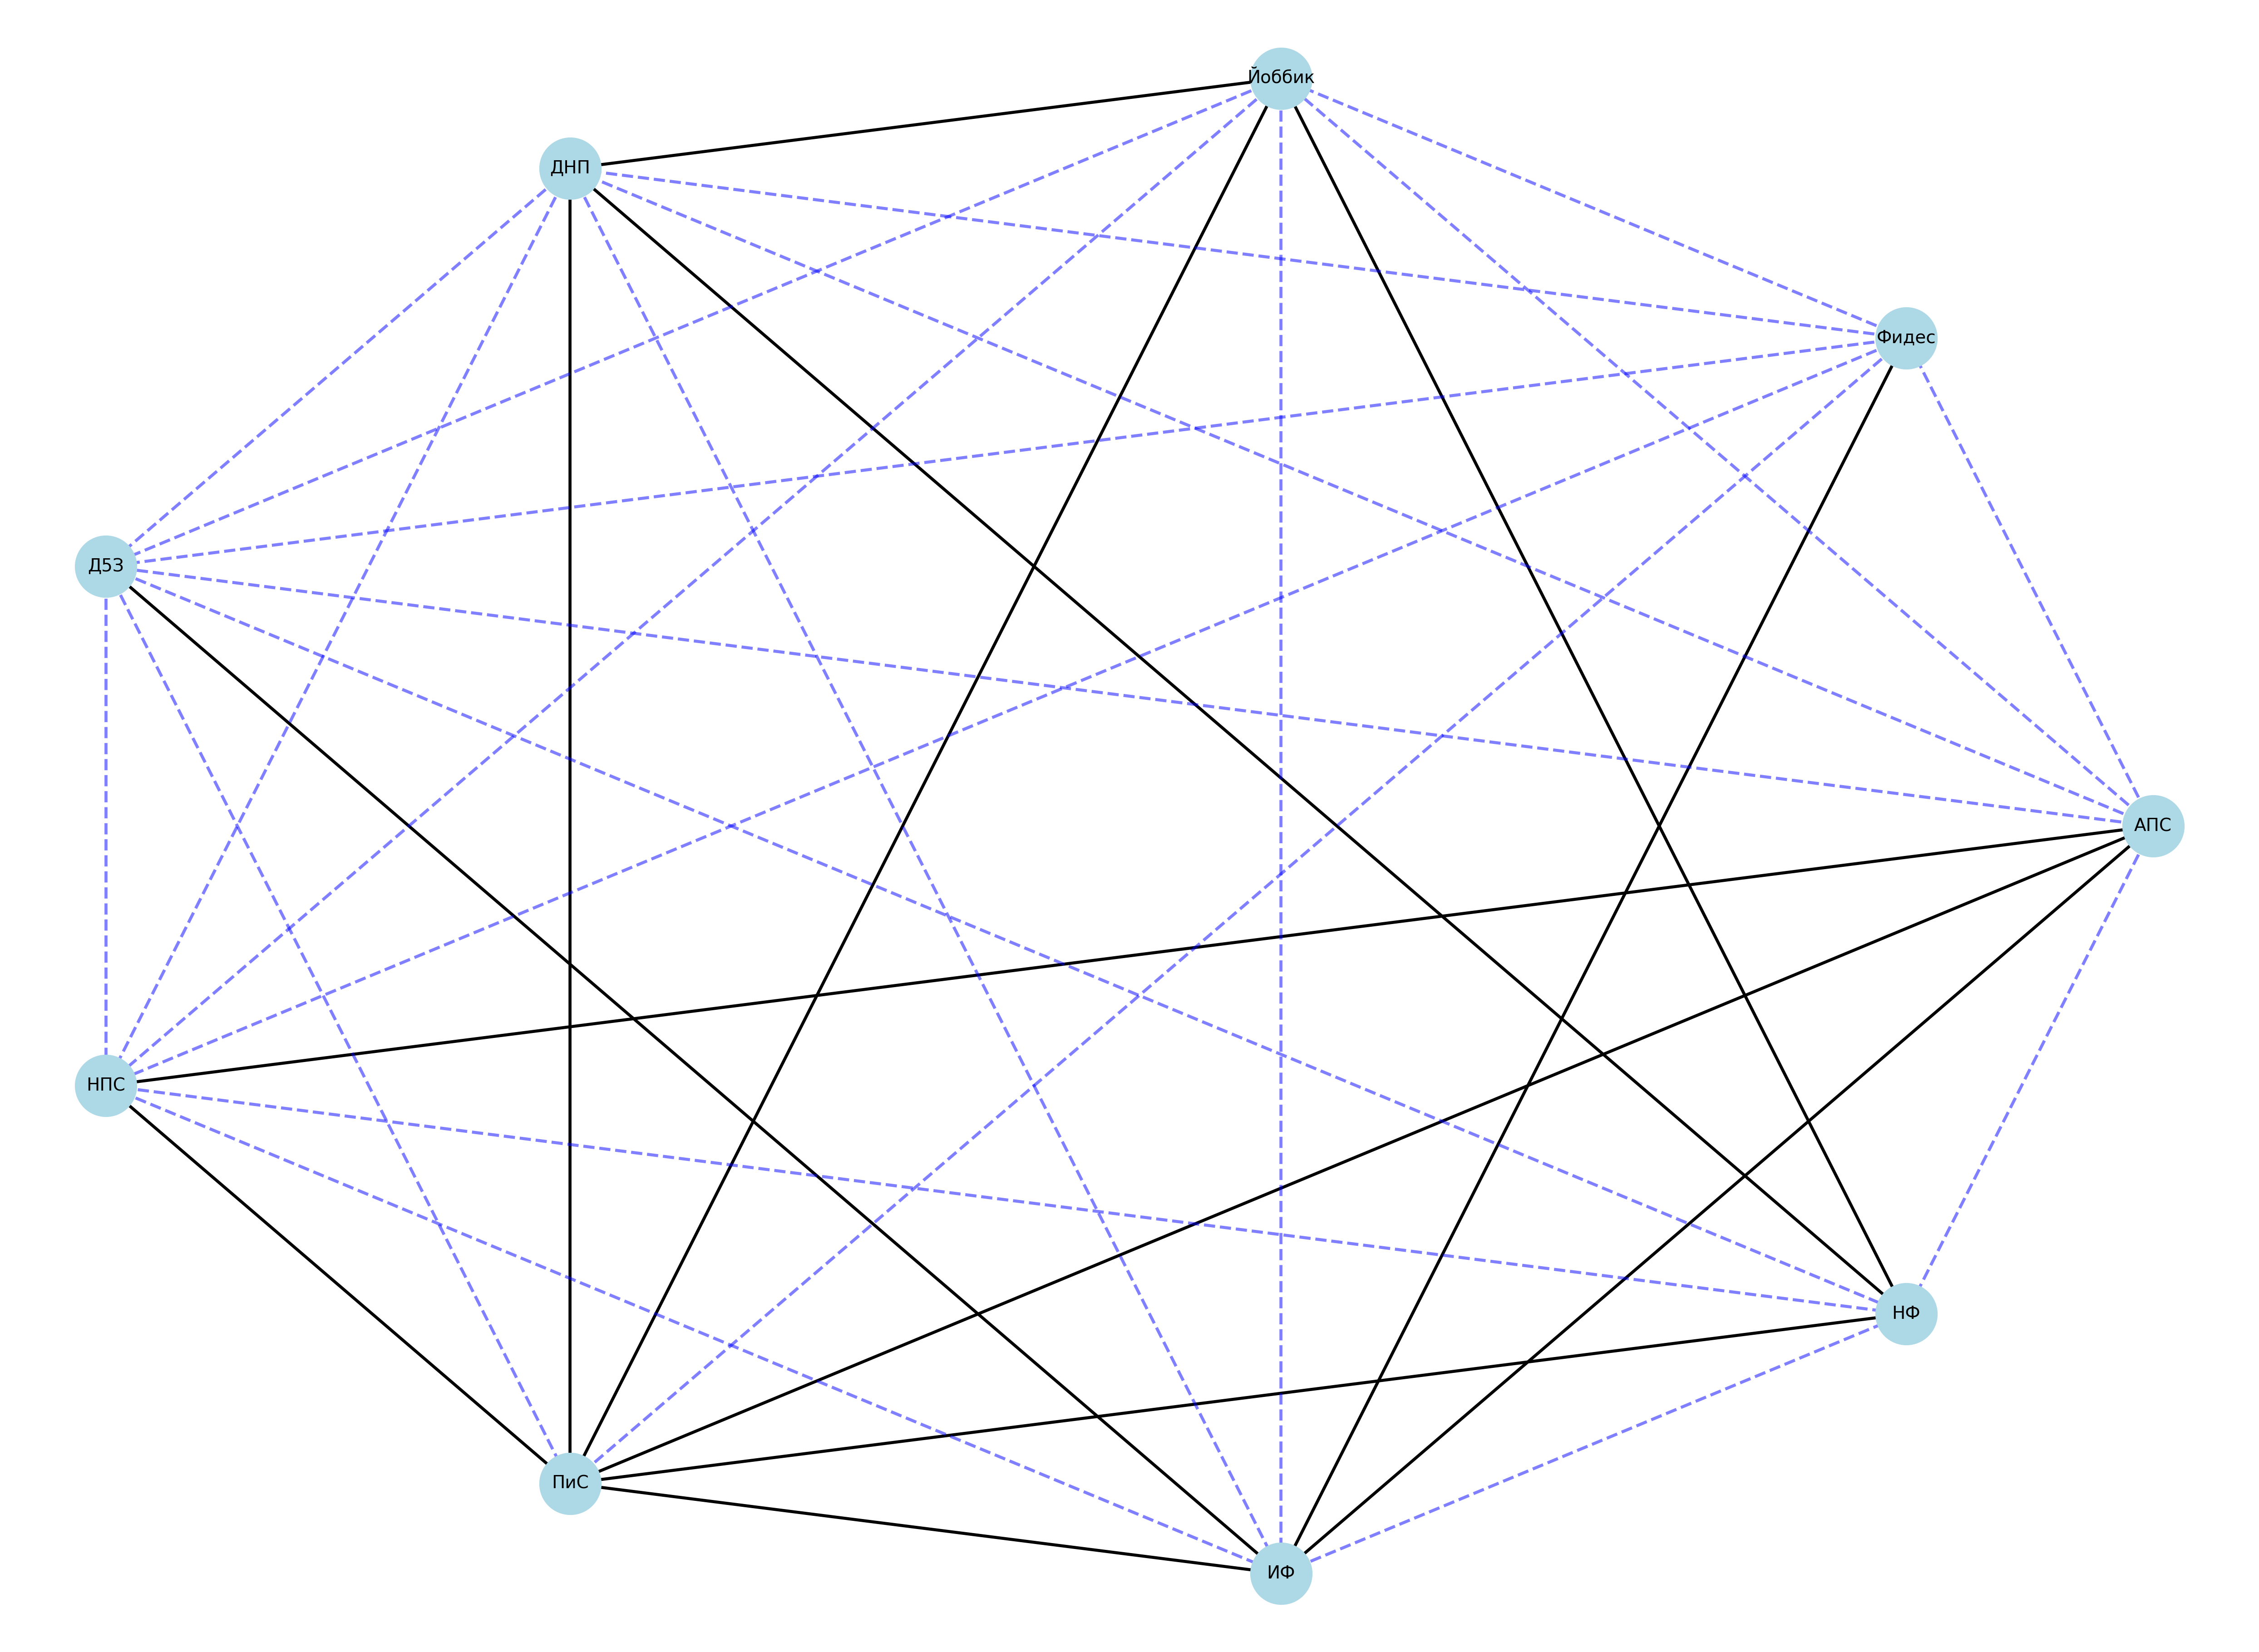

---Построим матрицу смежности и график без учета, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

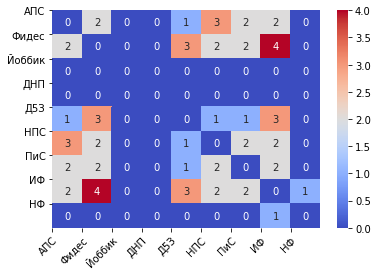

<Figure size 6400x4800 with 0 Axes>

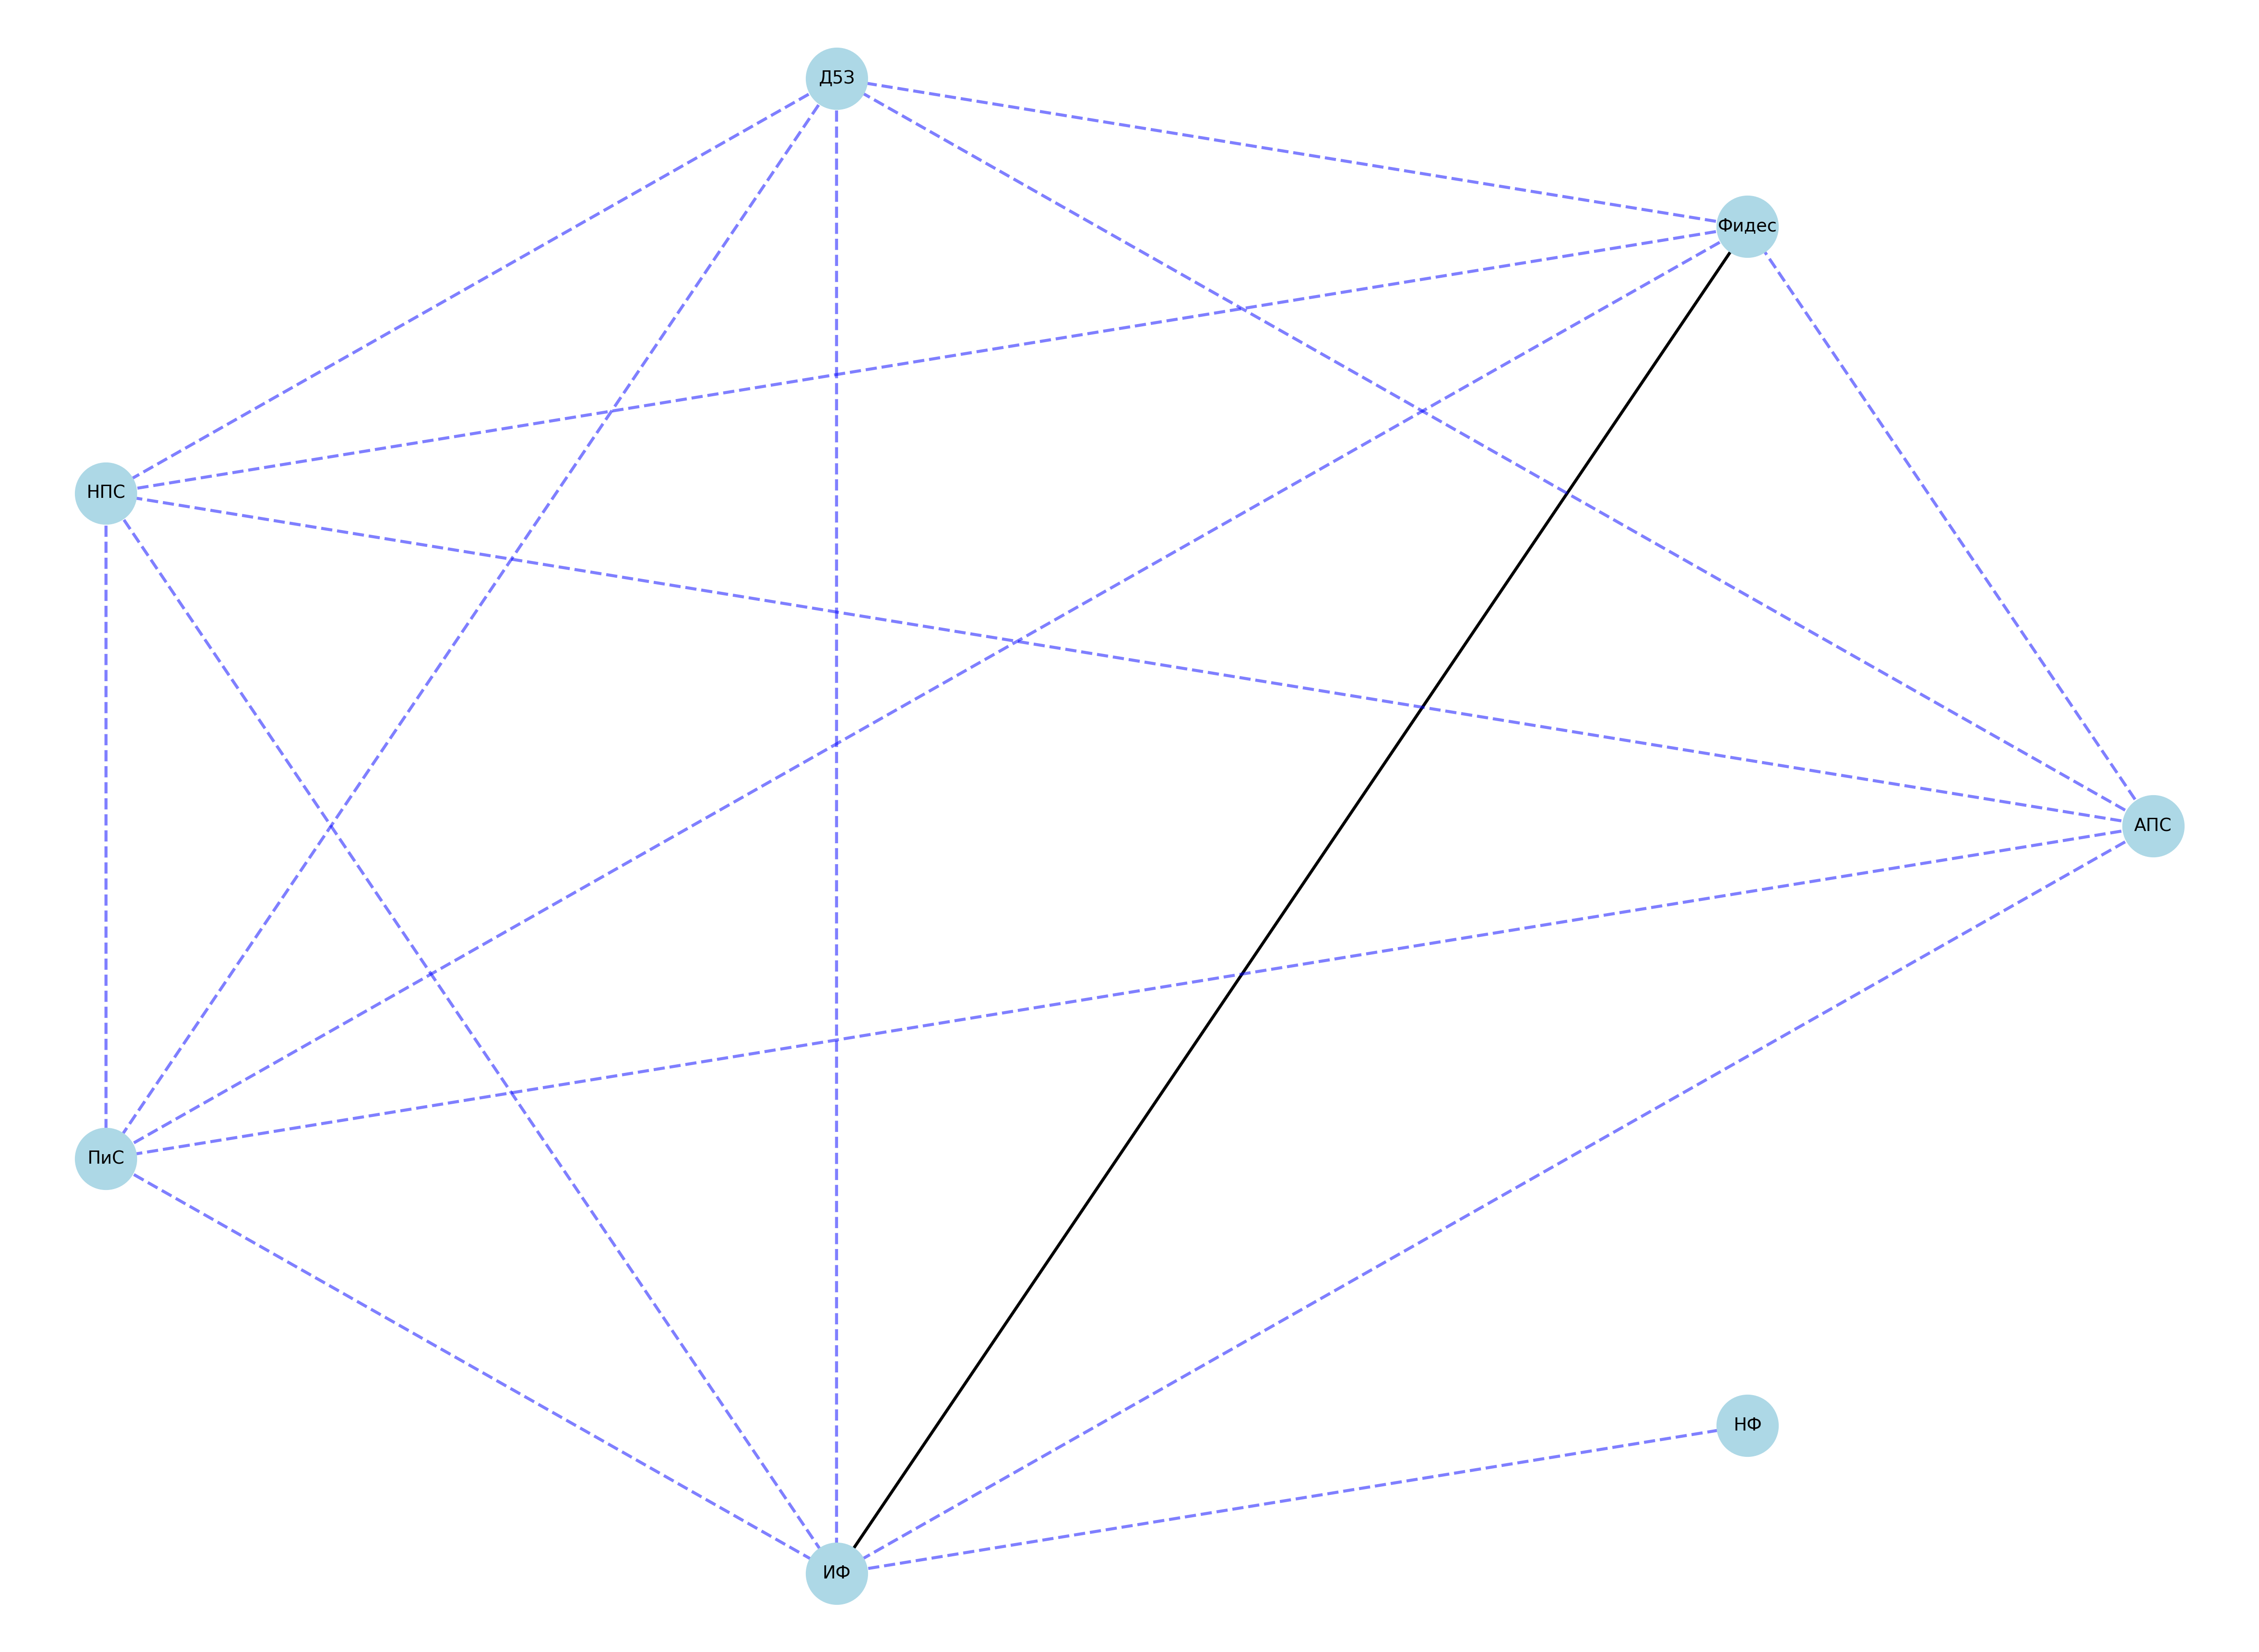

In [13]:
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt
import numpy as np

def data_parse_plotting(name, table_values=None, table_values_active=None):
  matrix, votes, parties = parse_excel(name)
  results = ['за', 'против', 'неучастие']
  format_matrix_to_numbers(matrix)
  components_all = get_components_list(matrix, 3)
  graph_matrix_all = make_graph_matrix(components_all)
  print('---Построим матрицу смежности и график с учетом, когда партии не принимали участия в голосовании')
  
  plt.figure(figsize=(20, 10))
  plot_heatmap(graph_matrix_all, parties)

  figure(figsize=(80, 60), dpi=80)
  draw_graph_matrix_adjency(graph_matrix_all, votes)
  
  print('---Построим матрицу смежности и график без учета, когда партии не принимали участия в голосовании')
  components1 = get_components_list(matrix, 2)
  graph_matrix_active = make_graph_matrix(components1)
  
  plt.figure(figsize=(20, 10))
  plot_heatmap(graph_matrix_active, parties)
  
  figure(figsize=(80, 60), dpi=80)
  draw_graph_matrix_adjency(graph_matrix_active, votes)
  if (table_values != None):
    values_list = []
    G = make_graph(graph_matrix_all, parties)
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    values_list.append(degree)
    values_list.append(betweenness)
    values_list.append(closeness)
    values_list.append(nx.average_clustering(G))
    values_list.append(nx.density(G))
    table_values.append(values_list)
  if (table_values_active != None):
    values_list = []
    G = make_graph(graph_matrix_active, parties)
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    values_list.append(degree)
    values_list.append(betweenness)
    values_list.append(closeness)
    values_list.append(nx.average_clustering(G))
    values_list.append(nx.density(G))
    table_values_active.append(values_list)

values_matrix = []
values_matrix_active = []
data_parse_plotting('first.xlsx', table_values= values_matrix, table_values_active=values_matrix_active)

Теперь мы также должны обработать второй файл с голосованием по сельскому хозяйству:

---Построим матрицу смежности и график с учетом, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

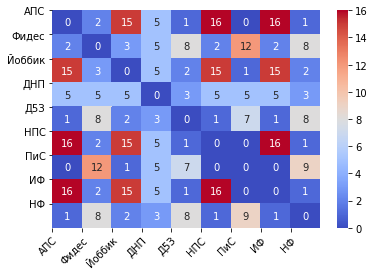

<Figure size 6400x4800 with 0 Axes>

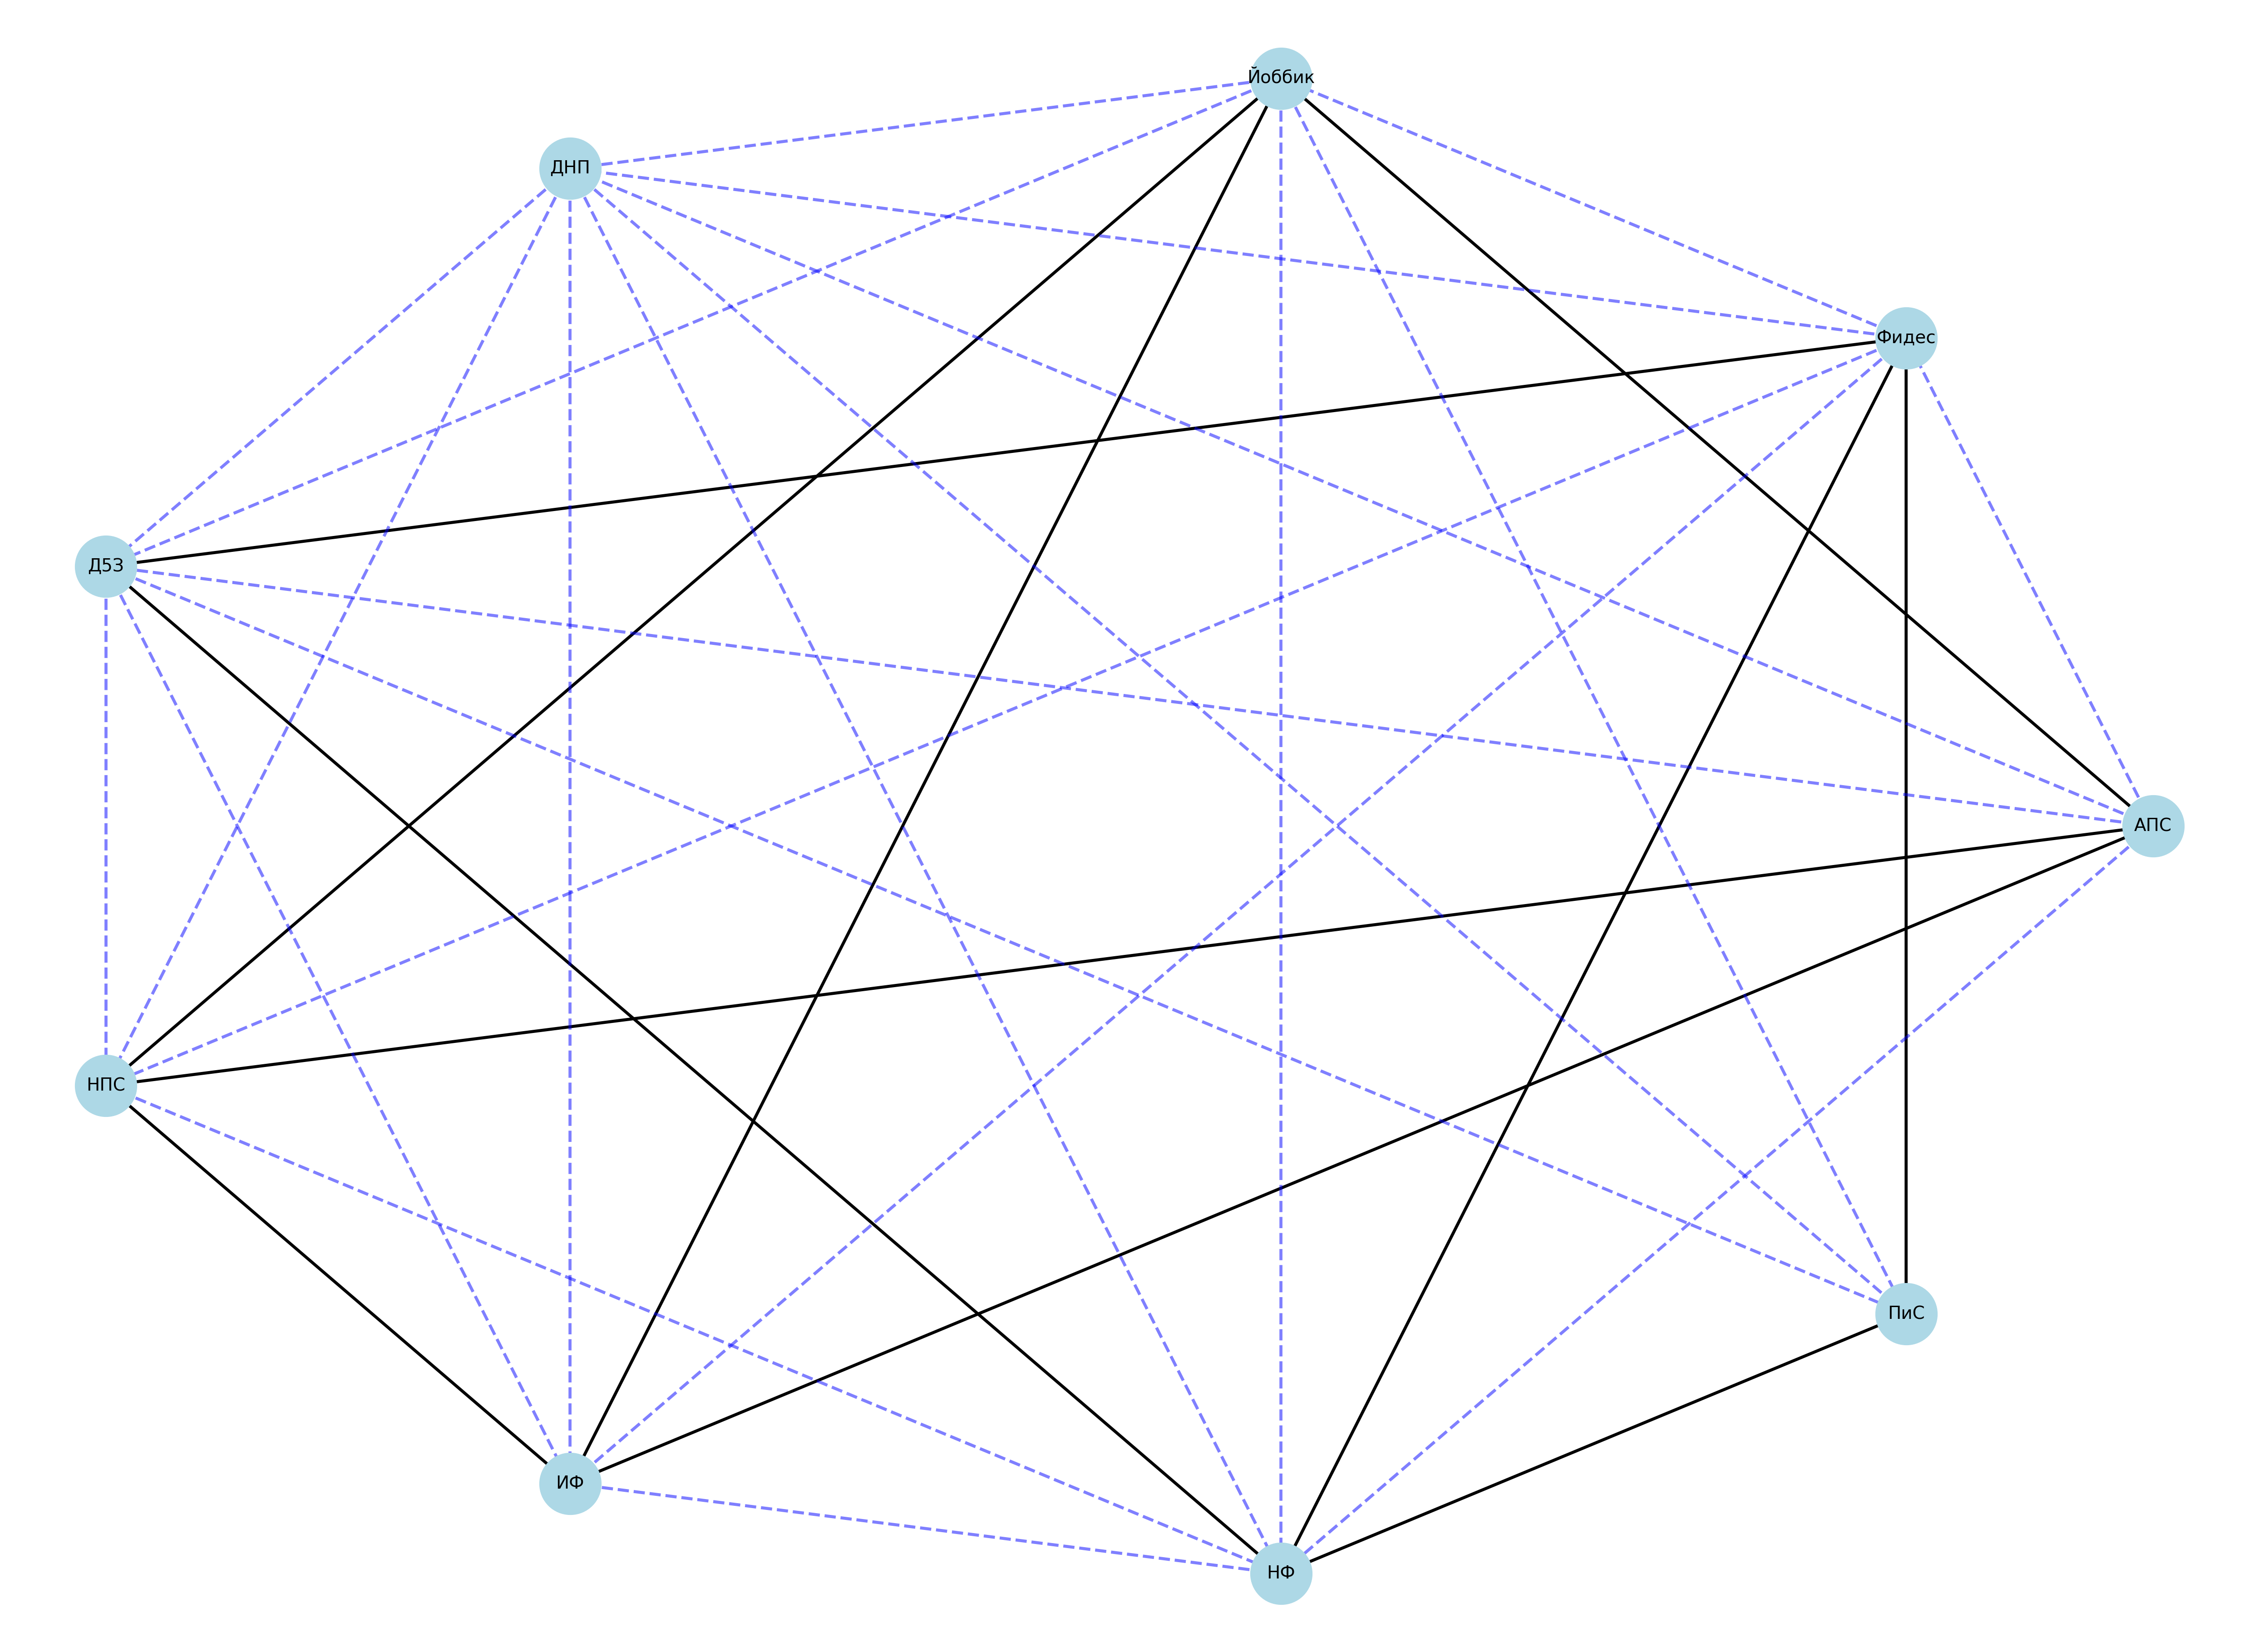

---Построим матрицу смежности и график без учета, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

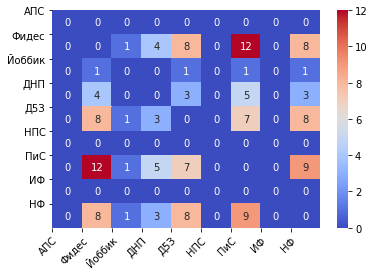

<Figure size 6400x4800 with 0 Axes>

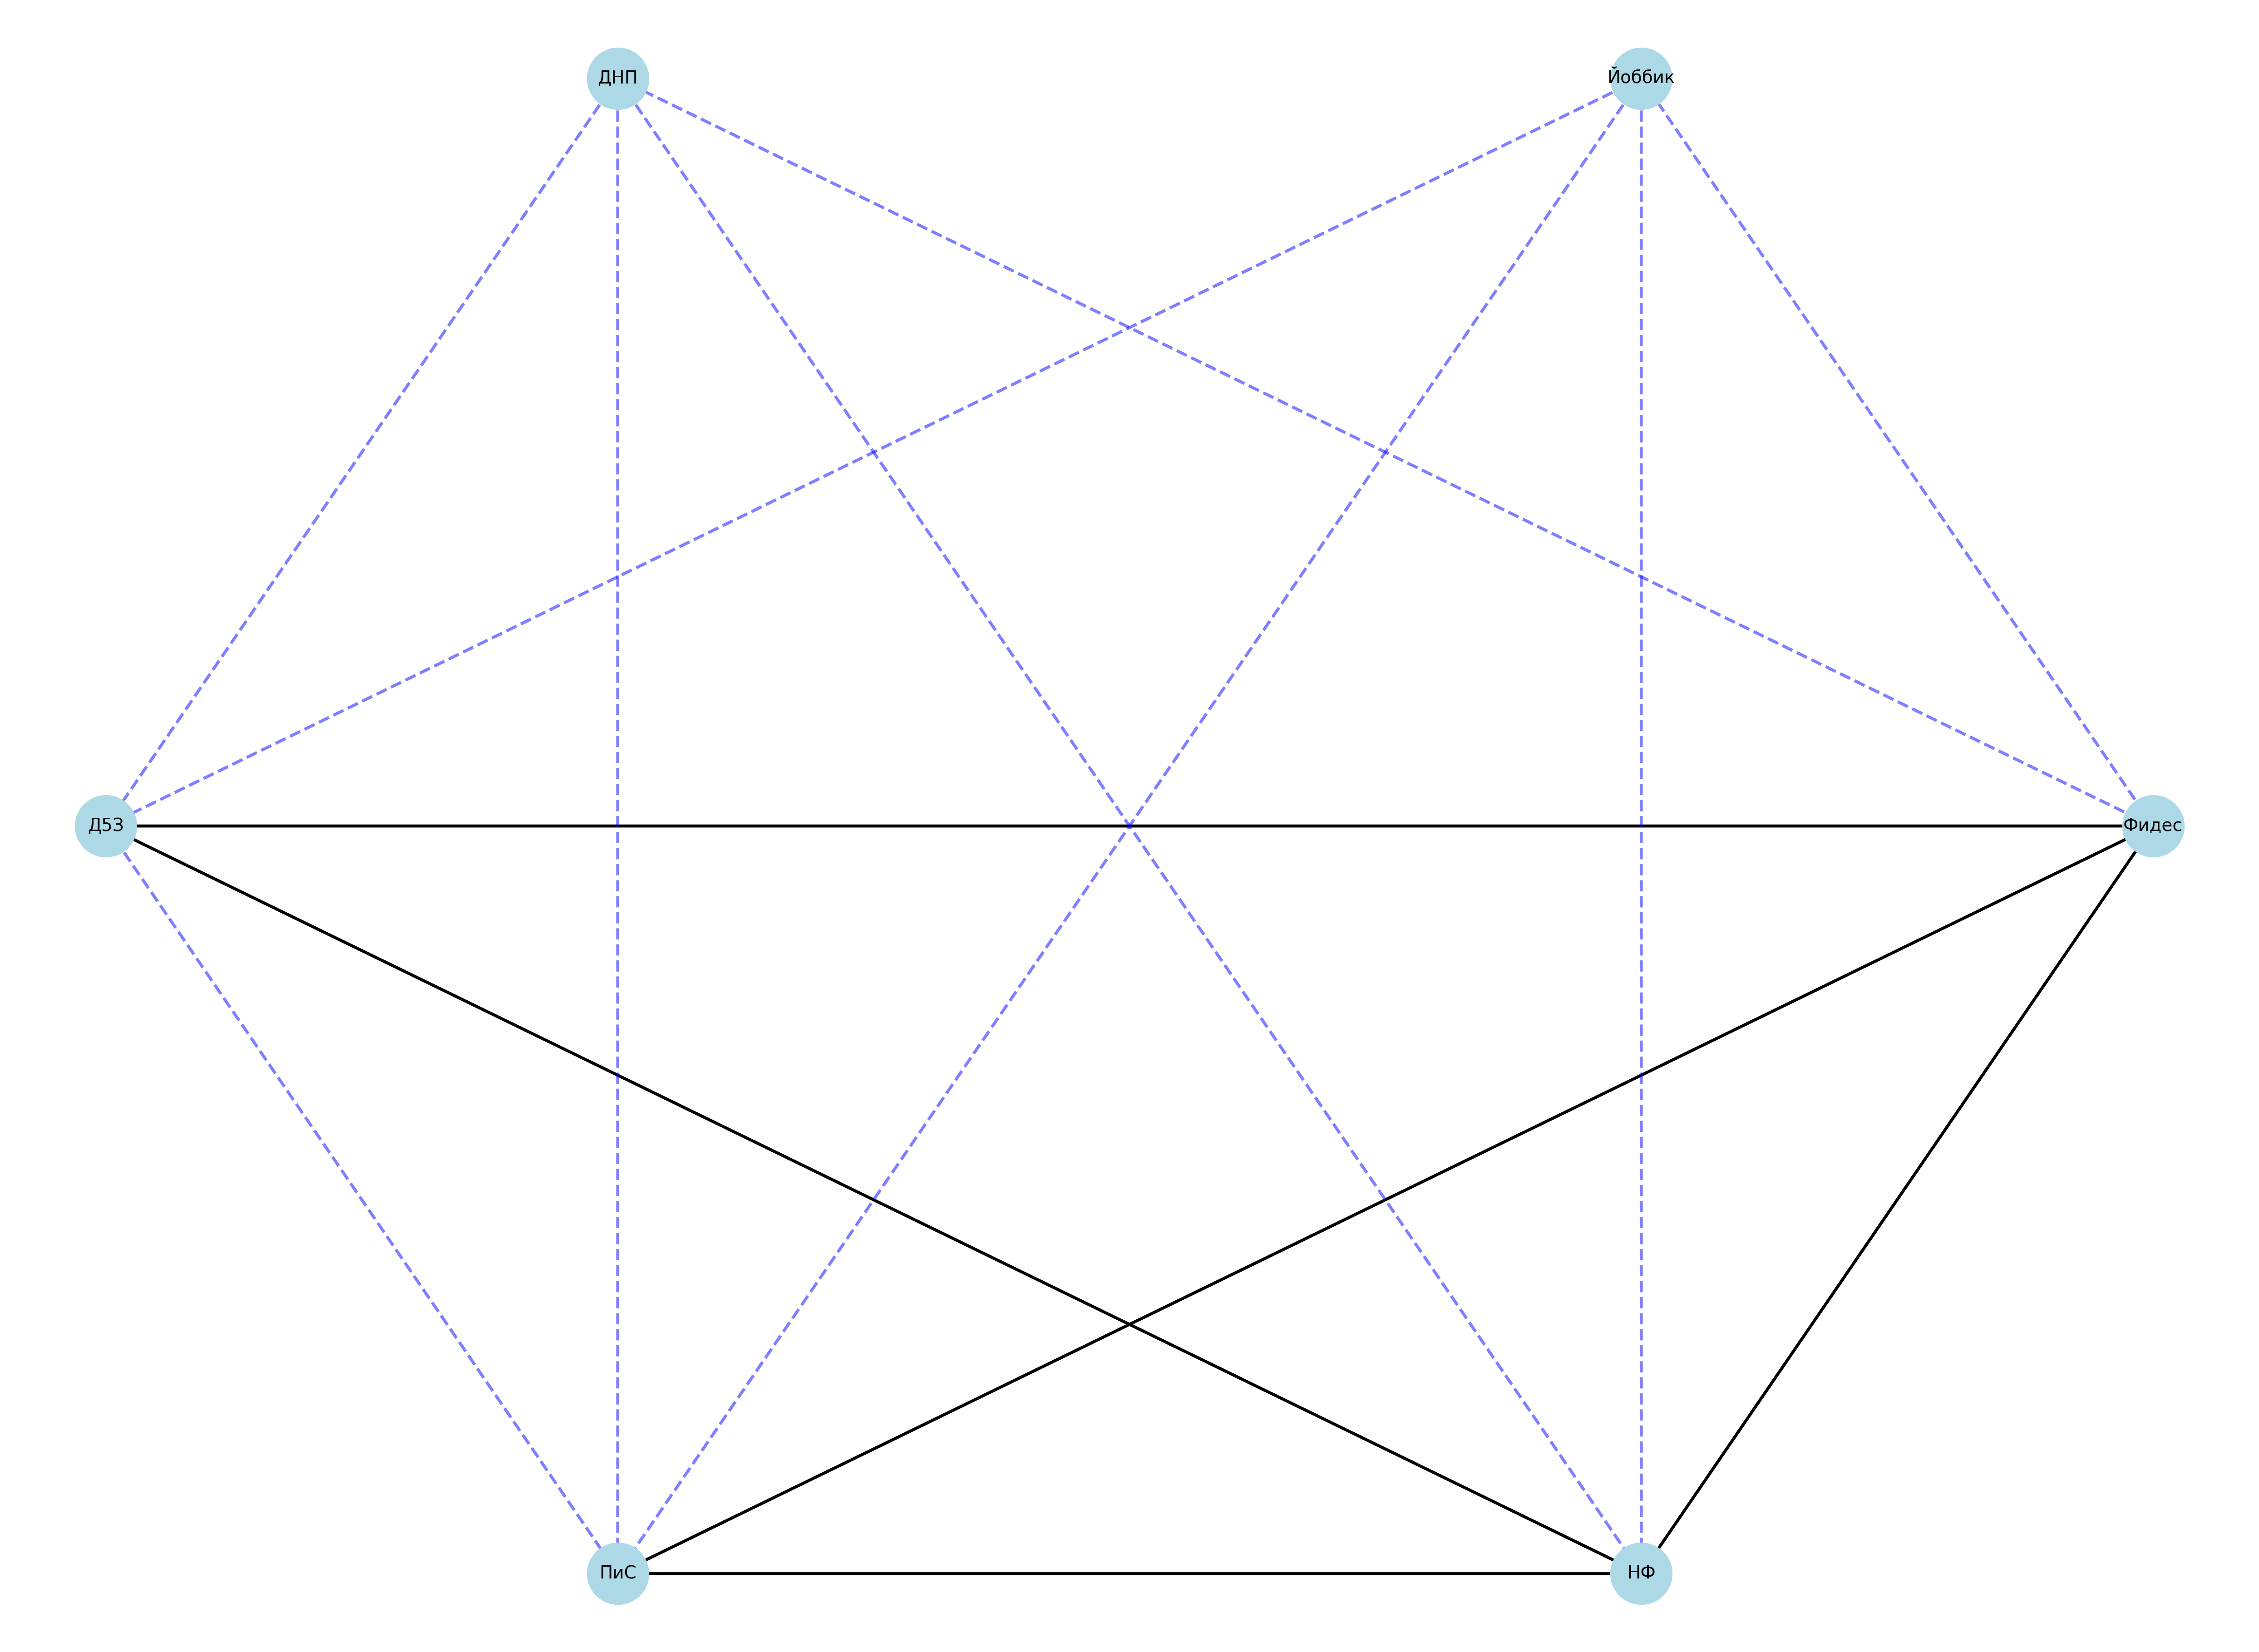

In [14]:
data_parse_plotting('second.xlsx', values_matrix, table_values_active=values_matrix_active)

Также обработаем голосования по экологии:

---Построим матрицу смежности и график с учетом, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

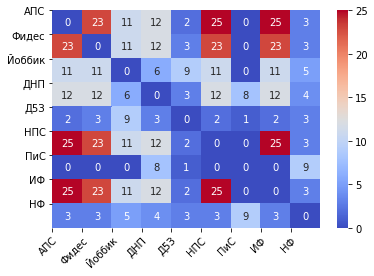

<Figure size 6400x4800 with 0 Axes>

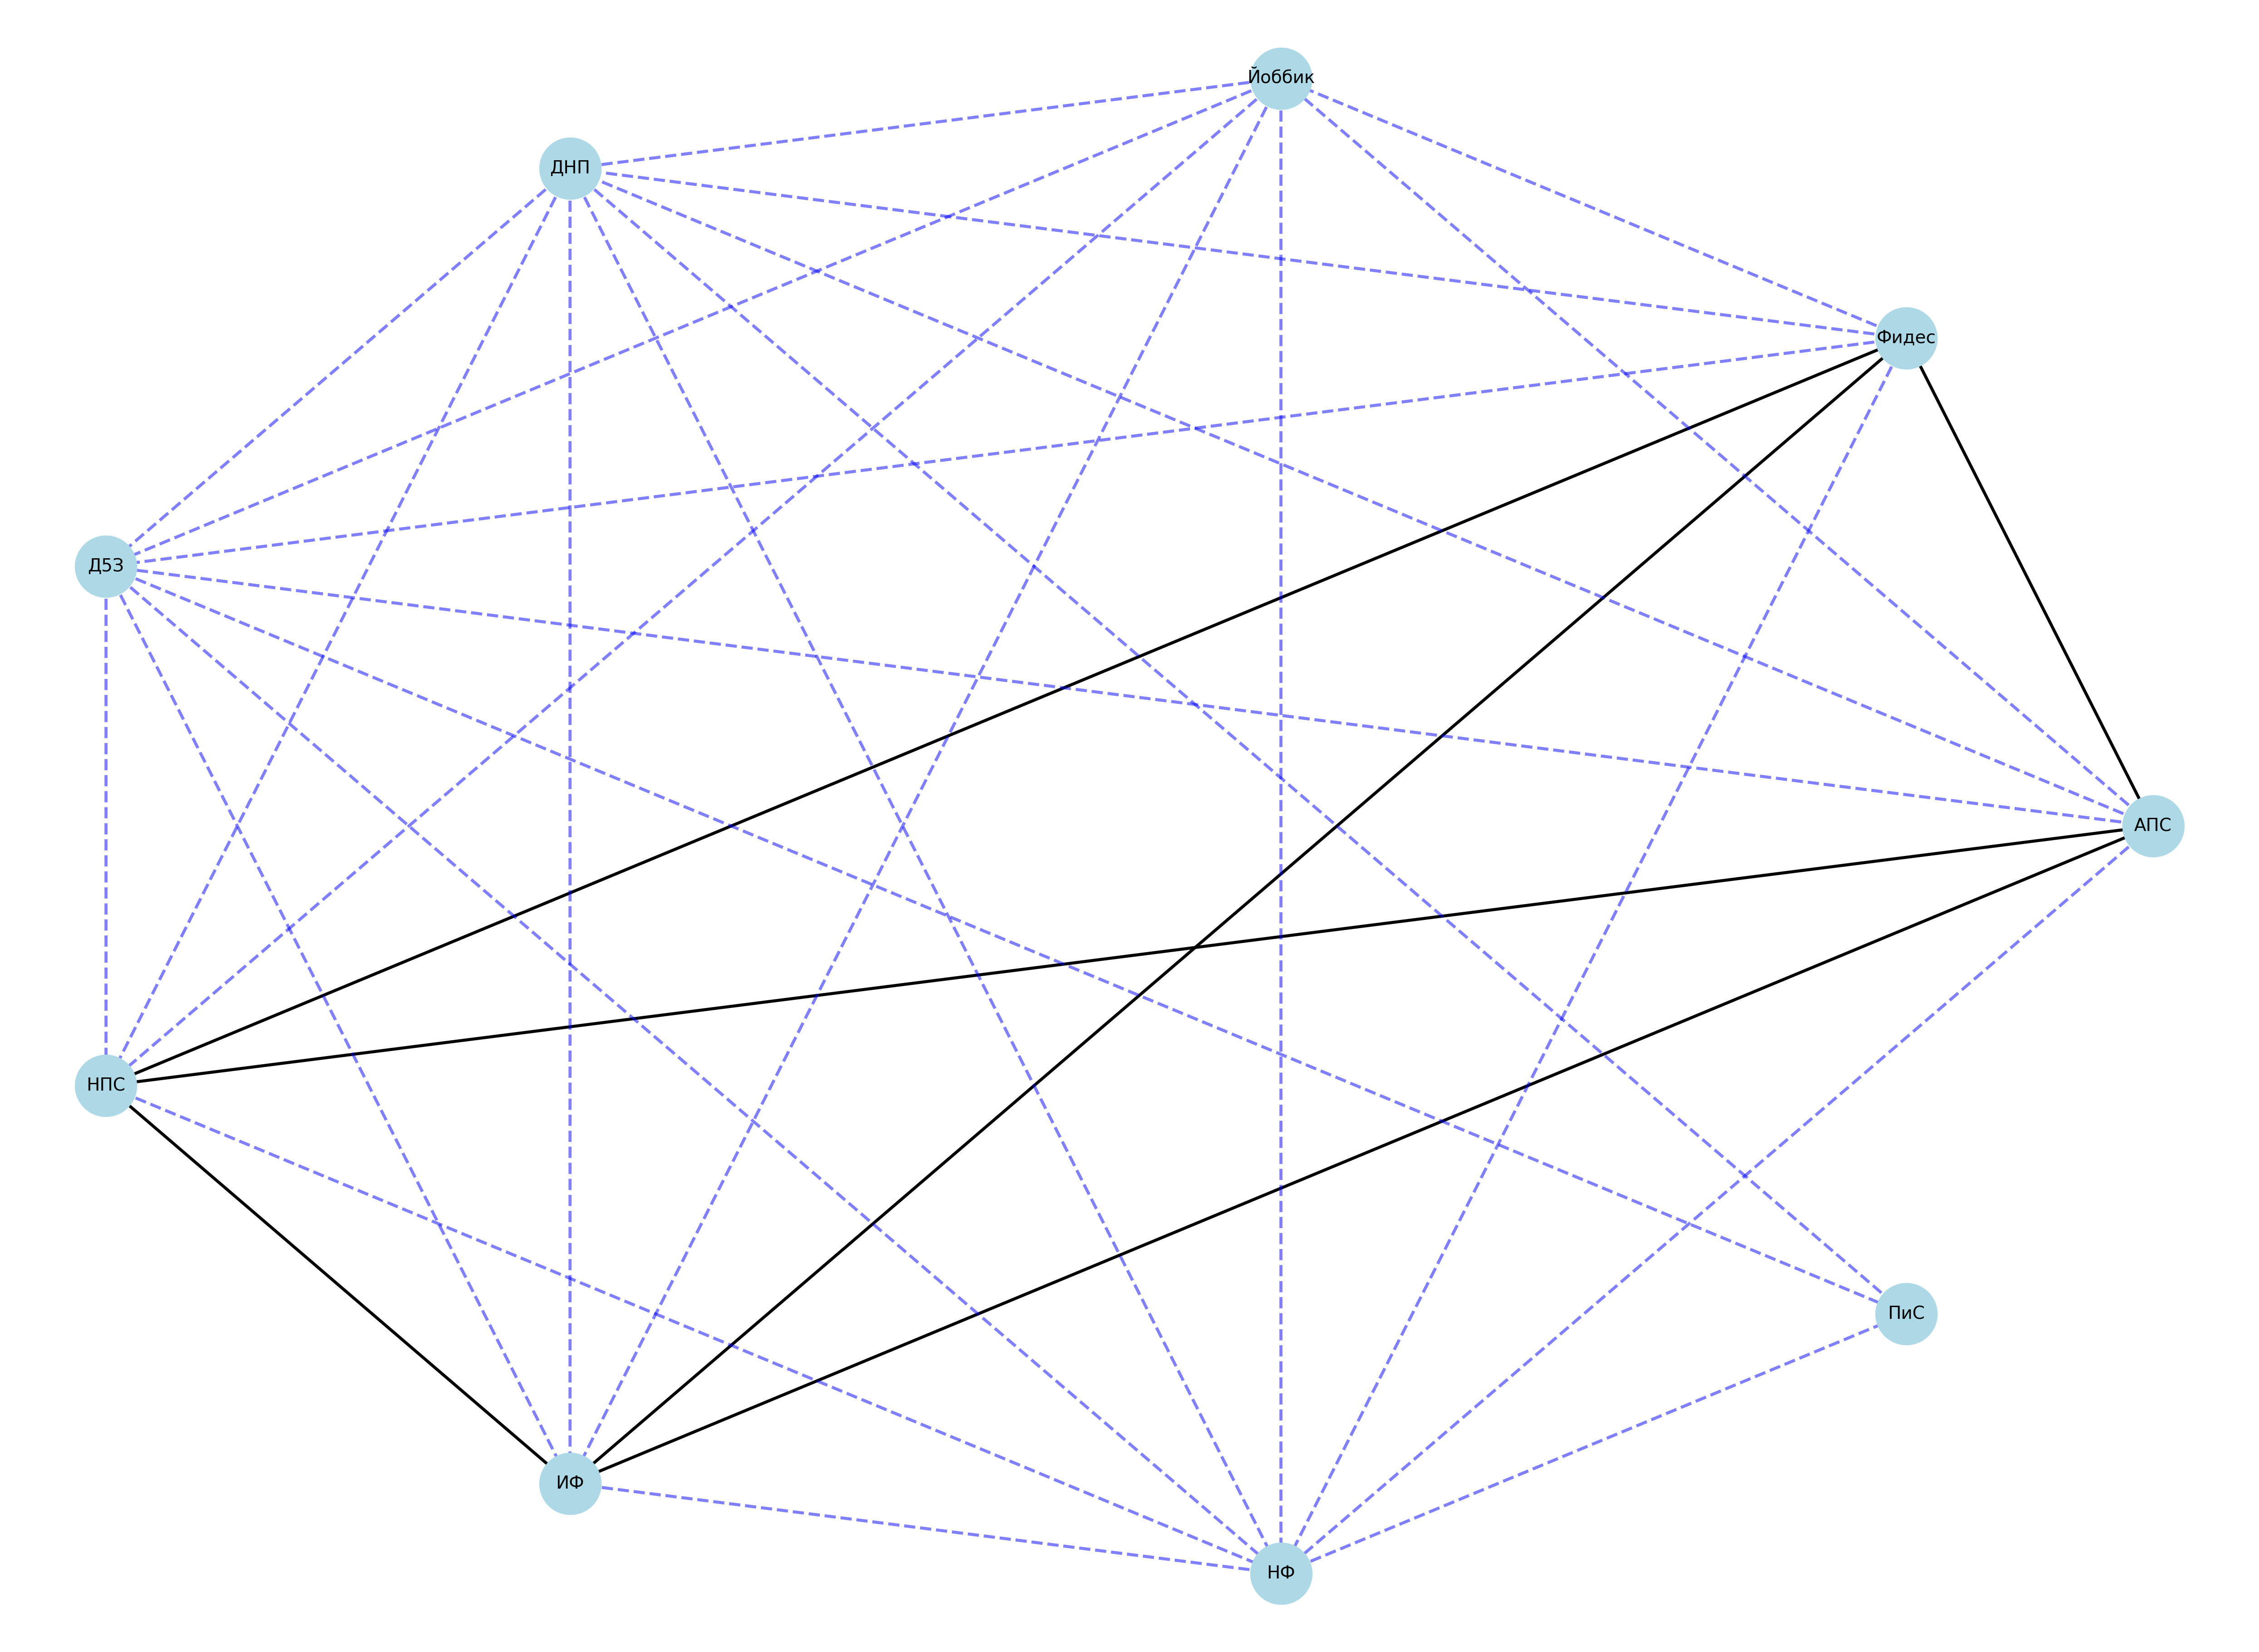

---Построим матрицу смежности и график без учета, когда партии не принимали участия в голосовании


<Figure size 1440x720 with 0 Axes>

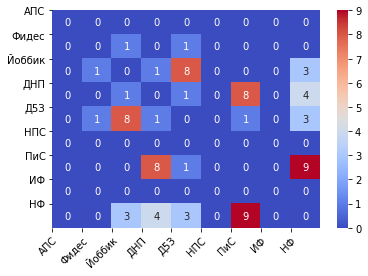

<Figure size 6400x4800 with 0 Axes>

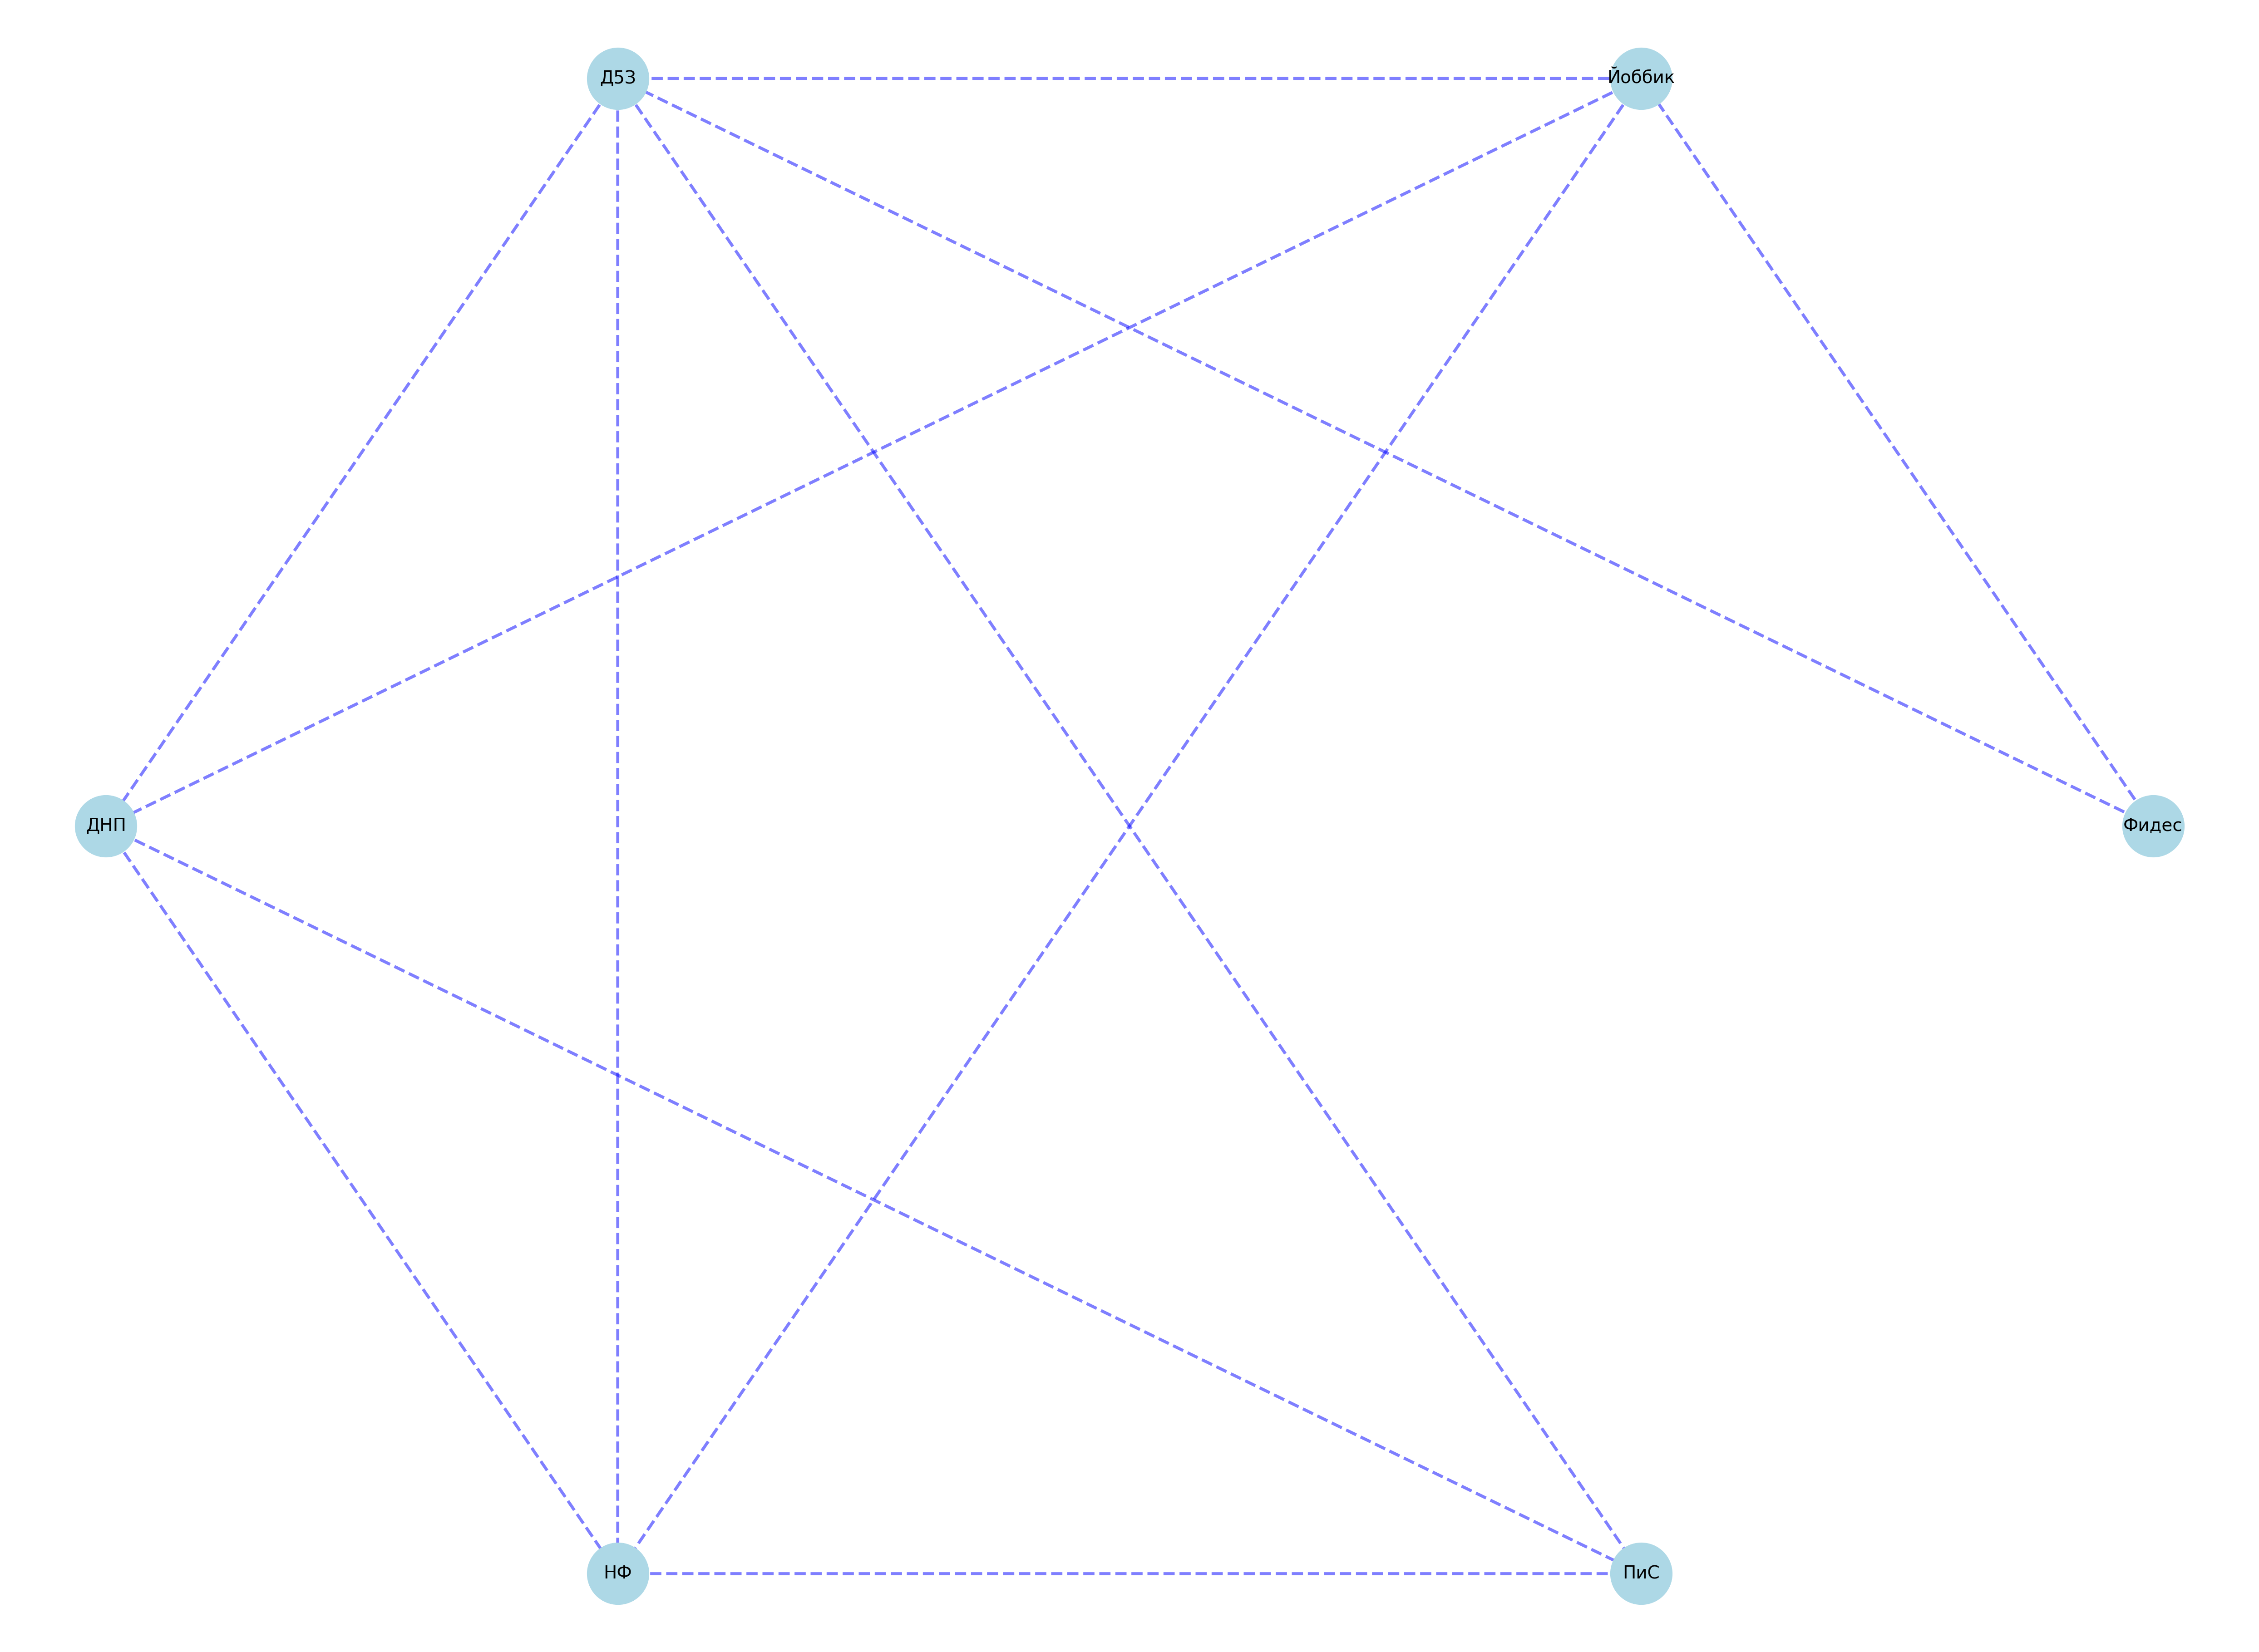

In [15]:
data_parse_plotting('third.xlsx', values_matrix, table_values_active=values_matrix_active)

Теперь формируем таблицу, состоящую из значений

In [16]:
claster_density_matrix = []
for i in values_matrix:
  claster_density_matrix.append(i[3:])
claster_density_matrix_active = []
for i in values_matrix_active:
  claster_density_matrix_active.append(i[3:])
(pd.DataFrame(claster_density_matrix, ['Миграционная политика', 'Сельскохозяйственная политика', 'Экологическая политика'], ['Коэффициент кластеризации', 'Плотность']))


#     pd.DataFrame(values_matrix[i][j].items())

Коэффициент кластеризации  Плотность
Миграционная политика                           0.972222   0.972222
Сельскохозяйственная политика                   0.940476   0.916667
Экологическая политика                          0.940476   0.861111

Добавим таблицу по коэффициентам без неучастия

In [17]:
(pd.DataFrame(claster_density_matrix_active, ['Миграционная политика', 'Сельскохозяйственная политика', 'Экологическая политика'], ['Коэффициент кластеризации', 'Плотность']))


Коэффициент кластеризации  Плотность
Миграционная политика                           0.629630   0.444444
Сельскохозяйственная политика                   0.622222   0.388889
Экологическая политика                          0.548148   0.305556

Теперь построим таблицу по коэффициентам централизации c неучастием

In [ ]:
polices = ['Миграционная политика', 'Сельскохозяйственная политика', 'Экологическая политика']
centrality = ['По степени', 'По посредничеству', 'По близости']
def draw_centrality_table(k):
  p = list(values_matrix[0][0].keys())
  print(polices[k])
  centrality1_matrix = []
  for i in range(0, len(p)):
    centrality1_matrix.append([])
    for j in range(0, 3):
      centrality1_matrix[i].append(values_matrix[k][j][p[i]])
  return centrality1_matrix

def draw_centrality_table_active(k):
  print(polices[k])
  p = list(values_matrix[0][0].keys())
  centrality1_matrix = []
  for i in range(0, len(p)):
    centrality1_matrix.append([])
    for j in range(0, 3):
      if p[i] in values_matrix_active[k][j].keys():
        centrality1_matrix[i].append(values_matrix_active[k][j][p[i]])
  return centrality1_matrix

(pd.DataFrame(draw_centrality_table(0), p, centrality))


Миграционная политика


По степени  По посредничеству  По близости
АПС          1.000           0.010204     1.000000
Фидес        0.875           0.005102     0.888889
Йоббик       1.000           0.010204     1.000000
ДНП          1.000           0.010204     1.000000
Д5З          0.875           0.005102     0.888889
НПС          0.875           0.005102     0.888889
ПиС          1.000           0.010204     1.000000
ИФ           1.000           0.010204     1.000000
НФ           0.875           0.005102     0.888889

Миграционная политика без неучастия

In [ ]:
(pd.DataFrame(draw_centrality_table_active(0), list(values_matrix[0][0].keys()), centrality))


Миграционная политика


По степени  По посредничеству  По близости
АПС          0.500           0.000000     0.562500
Фидес        0.625           0.053571     0.642857
Йоббик       0.000           0.000000     0.000000
ДНП          0.000           0.000000     0.000000
Д5З          0.250           0.000000     0.450000
НПС          0.500           0.000000     0.562500
ПиС          0.500           0.000000     0.562500
ИФ           0.750           0.232143     0.750000
НФ           0.125           0.000000     0.409091

Сельское хозяйство с неучастием

In [ ]:
(pd.DataFrame(draw_centrality_table(1), list(values_matrix[0][0].keys()), centrality))


Сельскохозяйственная политика


По степени  По посредничеству  По близости
АПС          0.875           0.000000     0.888889
Фидес        1.000           0.021429     1.000000
Йоббик       1.000           0.021429     1.000000
ДНП          1.000           0.021429     1.000000
Д5З          1.000           0.021429     1.000000
НПС          0.875           0.000000     0.888889
ПиС          0.625           0.000000     0.727273
ИФ           0.875           0.000000     0.888889
НФ           1.000           0.021429     1.000000

Сельское хозяйство без неучастия

In [ ]:
(pd.DataFrame(draw_centrality_table_active(1), list(values_matrix[0][0].keys()), centrality))


Сельскохозяйственная политика


По степени  По посредничеству  По близости
АПС          0.000           0.000000     0.000000
Фидес        0.625           0.008929     0.625000
Йоббик       0.500           0.000000     0.520833
ДНП          0.500           0.000000     0.520833
Д5З          0.625           0.008929     0.625000
НПС          0.000           0.000000     0.000000
ПиС          0.625           0.008929     0.625000
ИФ           0.000           0.000000     0.000000
НФ           0.625           0.008929     0.625000

Экология с неучастием:

In [ ]:
(pd.DataFrame(draw_centrality_table(2), list(values_matrix[0][0].keys()), centrality))


Экологическая политика


По степени  По посредничеству  По близости
АПС          0.875           0.000000     0.888889
Фидес        0.875           0.000000     0.888889
Йоббик       0.875           0.000000     0.888889
ДНП          1.000           0.059524     1.000000
Д5З          1.000           0.059524     1.000000
НПС          0.875           0.000000     0.888889
ПиС          0.375           0.000000     0.615385
ИФ           0.875           0.000000     0.888889
НФ           1.000           0.059524     1.000000

Экология без неучастия:

In [ ]:
(pd.DataFrame(draw_centrality_table_active(2), list(values_matrix[0][0].keys()), centrality))


Экологическая политика


По степени  По посредничеству  По близости
АПС          0.000           0.000000     0.000000
Фидес        0.250           0.000000     0.390625
Йоббик       0.500           0.035714     0.520833
ДНП          0.500           0.011905     0.520833
Д5З          0.625           0.083333     0.625000
НПС          0.000           0.000000     0.000000
ПиС          0.375           0.000000     0.446429
ИФ           0.000           0.000000     0.000000
НФ           0.500           0.011905     0.520833